# Introduction

Github project adapted from content taught in DSC 190: Spring '21 with Justin Eldridge

In this notebook, I will explore Gaussian Radial Basis Networks and their utility in classification tasks

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import sklearn.datasets
import sklearn.model_selection
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Generate Data

Consider the data set below:

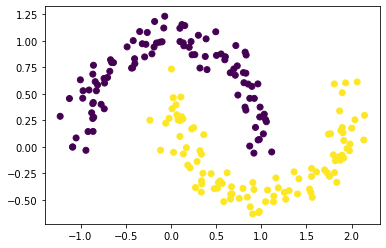

In [2]:
np.random.seed(42)
X_moons, y_moons = sklearn.datasets.make_moons(200, noise=.1)
y_moons = (y_moons - .5) * 2

plt.scatter(*X_moons.T, c=y_moons)

Here, `X_moons` represents a training set of points in $\mathbb R^2$ and `y_moons` contains the label of each training point.

## Simple Least Squares Classification

We will build a simple least squares linear predictor to determine base classification accuracy

In [3]:
aug = np.column_stack((np.ones(len(X_moons)), X_moons))
w = np.linalg.lstsq(aug, y_moons)[0]

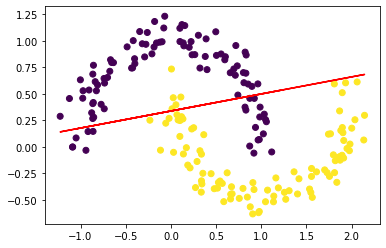

In [4]:
plt.scatter(*X_moons.T, c=y_moons)
plt.plot(X_moons, w[0] * X_moons + w[1], 'r', label='Fitted line')

In [5]:
preds = aug @ w

def binarize(val):
    if val < 0:
        return -1
    else:
        return 1

preds = np.array(list(map(binarize, preds)))

### Classification Accuracy

In [6]:
(preds == y_moons).sum() / 200

0.87

The classification accuracy with the current representation in $\mathbb R^2$ is not satisfactory


# Gaussian RBF Feature Engineering

We shall design four radial basis functions, $\varphi_1, \ldots, \varphi_4$ to transform this data in $\mathbb R^2$ into a new representation in $\mathbb R^4$ where binary classification becomes easier. The following functions take in the entire data matrix, `X`, and return an array containing the new feature for each training point.

In [7]:
def phi_1(X):
    mu = (-1, 0.25)
    return np.exp(-np.abs(np.linalg.norm(X-mu, axis=-1))**2 / 1.5**2)
    
def phi_2(X):
    mu = (1, 0.25)
    return np.exp(-np.abs(np.linalg.norm(X-mu, axis=-1))**2 / 1.5**2)

def phi_3(X):
    mu = (0, 0)
    return np.exp(-np.abs(np.linalg.norm(X-mu, axis=-1))**2 / 1.5**2)

def phi_4(X):
    mu = (2, 0)
    return np.exp(-np.abs(np.linalg.norm(X-mu, axis=-1))**2 / 1.5**2)

In [8]:
phi1 = phi_1(X_moons)
phi2 = phi_2(X_moons)
phi3 = phi_3(X_moons)
phi4 = phi_4(X_moons)
rbfs = [phi1, phi2, phi3, phi4]

We must select a set of points $\mu_1, \ldots \mu_4$ to be centers for our functions $\varphi_1, \ldots, \varphi_4$

In [9]:
mus = np.array([(-1, 0.25), (1, 0.25), (0, 0), (2, 0)])

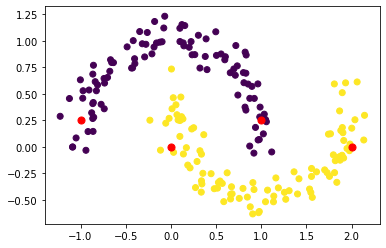

In [10]:
plt.scatter(*X_moons.T, c=y_moons)
plt.scatter(*mus.T, s=50, c='r')

Above, I selected the points $(-1, 0.25), (1, 0.25), (0, 0), (2, 0)$ as the centers for the RBFs

# Least Squares Classification: New Representation

In [11]:
aug = np.column_stack((np.ones(len(X_moons)), *rbfs))
w = np.linalg.lstsq(aug, y_moons)[0]

In [12]:
preds = aug @ w

def binarize(val):
    if val < 0:
        return -1
    else:
        return 1

preds = np.array(list(map(binarize, preds)))

### Classification Accuracy

In [13]:
(preds == y_moons).sum() / 200

0.98

This is a satisfactory classification accuracy for `X_moons`. But there is still scope to improve!

# More RBFs
By increasing the number of radial basis functions, we can make more complex decision boundaries with higher classification accuracy. Below is an example of a Gaussian network with a decision boundary achieving 100% accuracy

In [14]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="Decision Boundary.png", width=400, height=400)

# Prediction Surface
Let us examine the Gaussian prediction surface in 3 dimensions

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="Prediction Surface.png", width=400, height=400)

# Achieving better $\mu$ with k-means

In the moons example above, we see that there are two well defined clusters in $\mathbb R^2$, so choosing good centers for classification is relatively easy. What about when the data is high dimensional?

The cell below creates a training set `X_train` with labels `y_train`, as well as a testing set `X_test` with labels `y_test`. Each data matrix `X_train` and `X_test` has four columns, each representing one feature.

In [15]:
np.random.seed(42)
X, y = sklearn.datasets.make_blobs(2000, 4, centers=20)
X = X * 10

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.3)
y_train = np.where(y_train <= 10, 1, -1)
y_test = np.where(y_test <= 10, 1, -1)

If we were to train a least squares classifier on the training set directly, we would see that it has very poor performance (around 50% accuracy).

Instead, we shall train a Gaussian RBF Network with centers chosen via k-means. We will also need choose all of the parameters of the model, including $k$ and the width of the Gaussians.

In [16]:
def augment(X):
    return np.column_stack((np.ones(len(X)), X))

In [17]:
def make_rbf(mu, sigma):
    def rbf(x):
        return np.exp(-np.linalg.norm(x - mu, axis=1)**2 / sigma**2)
    return rbf

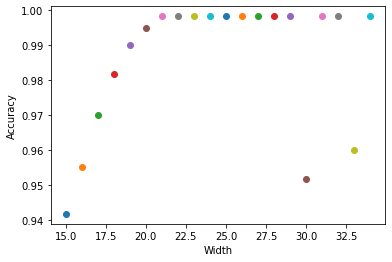

In [18]:
np.warnings.filterwarnings('ignore')

# determine sigma
for width in range(15,35):
    # elbow at k=20
    kmeans = KMeans(n_clusters=20)
    kmeans.fit(X_train)
    rbfs = [make_rbf(center, sigma=width) for center in kmeans.cluster_centers_]

    X_phi_train = np.column_stack([rbf(X_train) for rbf in rbfs])
    X_phi_test = np.column_stack([rbf(X_test) for rbf in rbfs])

    w = np.linalg.lstsq(augment(X_phi_train), y_train)[0]
    y_pred = augment(X_phi_test) @ w
    
    accuracy = (np.sign(y_pred) == y_test).mean()
    plt.scatter(x=width, y=accuracy)

plt.xlabel('Width')
plt.ylabel('Accuracy')
plt.show()

It appears that the ideal width for the Gaussians is 22

In [19]:
def predict(X):
    """
    Accept an n x 4 data matrix and apply your trained RBF network to
    return an array of predictions (either 1 or -1), one for each row of X
    """
    # elbow at k=20 
    kmeans = KMeans(n_clusters=20)
    kmeans.fit(X)
    # peak accuracy at sigma=22
    rbfs = [make_rbf(center, sigma=22) for center in kmeans.cluster_centers_]

    X_phi_train = np.column_stack([rbf(X_train) for rbf in rbfs])
    X_phi_test = np.column_stack([rbf(X_test) for rbf in rbfs])

    w = np.linalg.lstsq(augment(X_phi_train), y_train)[0]
    y_pred = augment(X_phi_test) @ w
    
    return np.sign(y_pred)

In [20]:
(predict(X_test)== y_test).mean()

0.9933333333333333

Our model has attained over 99% accuracy